In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import phd_pkg

phd_pkg.viz.matplotlib_style()

In [50]:
constants = dict(O1=-15.3, O2=-13.9, O3=-9.7, 
                RBS1147=60, RBS446=124, RBS1027=260, RBS1=1220,
               Nns=4.6E6, n_sites=2, ep_AI=4.5,
               Ka=139, Ki=0.53, Oid=-17)

In [51]:
# Load the data from the lord and savior.
data = pd.read_csv('../data/ch1/Chure2019_summarized_data.csv', comment='#')
data = data[data['mutant']!='wt']
epRA_stats = pd.read_csv('../data/ch1/Chure2019_DNA_binding_energy_summary.csv')
epRA_stats = epRA_stats[epRA_stats['repressors']==260]
allo_stats = pd.read_csv('../data/ch1/Chure2019_KaKi_epAI_summary.csv')
allo_stats = allo_stats[allo_stats['operator']=='O2']

# Load the data from the old gods
very_old_gods = pd.read_csv('../data/ch1/Garcia2011_Brewster2014.csv', comment='#')
old_gods = pd.read_csv('../data/ch1/RazoMejia_2018.csv', comment='#')
old_gods['repressors'] *= 2
old_gods.rename(columns={'IPTG_uM':'IPTGuM', 'fold_change_A':'fold_change'},
    inplace=True)
old_gods = old_gods[old_gods['repressors'] > 0]


In [52]:
very_old_gods

,repressor,fold_change,author,operator,energy
0,22.420,0.798500,garcia,O3,-9.7
1,59.340,0.652400,garcia,O3,-9.7
2,124.000,0.621000,garcia,O3,-9.7
3,255.300,0.477300,garcia,O3,-9.7
4,1213.000,0.249400,garcia,O3,-9.7
...,...,...,...,...,...
61,538.300,0.002153,brewster,O1,-15.3
62,3.006,0.082230,brewster,Oid,-17.0
63,5.953,0.044160,brewster,Oid,-17.0
64,10.980,0.018840,brewster,Oid,-17.0


In [53]:
def pact(c, n, ka, ki, ep_ai,):
    numer = (1 + c / ka)**n
    denom = numer + np.exp(-ep_ai) * (1 + c / ki)**n
    return numer / denom

def bohr_parameter_allo(ep_r, R, n_ns, c, ka, ki, ep_ai, n=2):
    # Compute and return the Bohr.
    bohr = ep_r - np.log(pact(c, n, ka, ki, ep_ai)) - np.log(R / n_ns)
    return bohr

def bohr_parameter(ep_r, R, n_ns):
    bohr = ep_r - np.log(R / n_ns)
    return bohr

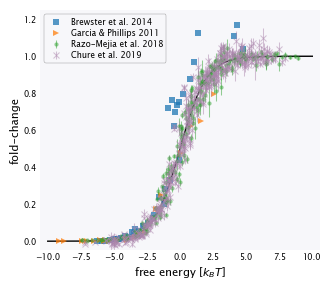

In [55]:
# Define plotting constants
bohr_range = np.linspace(-10, 10, 200)

# Define colors and glyphs
glyphs = {'garcia':'>', 'brewster':'s'}
#_color = {'garcia': colors['red'], 'brewster':colors['blue']}
legend = {'garcia': 'Garcia & Phillips 2011', 'brewster':'Brewster et al. 2014'}

# ##############################################################################
# FIGURE INSTANTIATION
# ##############################################################################
#%%
fig, ax = plt.subplots(1, 1, figsize=(3.42, 3))
ax.xaxis.set_tick_params(labelsize=6)
ax.yaxis.set_tick_params(labelsize=6)
ax.set_ylim([-0.05, 1.25])
ax.set_xlabel('free energy [$k_BT$]', fontsize=8)
ax.set_ylabel('fold-change', fontsize=8)

# ##############################################################################
# COLLAPSE CURVE
# ##########################3333333#3333########################################
ax.plot(bohr_range, (1 + np.exp(-bohr_range))**-1, 'k-', lw=1)

# ##############################################################################
# GARCIA AND BREWSTER DATA
# ##############################################################################
for g, d in very_old_gods.groupby('author'):
    ops = [constants[o] for o in d['operator'].values]
    bohr = bohr_parameter(R=d['repressor'], ep_r=ops, n_ns=constants['Nns'])
    ax.plot(bohr, d['fold_change'], marker=glyphs[g],
            linestyle='none', label=legend[g], markeredgewidth=0, alpha=0.75, 
            ms=4)

# ##############################################################################
# RAZO-MEJIA ET AL 2018
# ##############################################################################
old_gods_sum = old_gods.groupby(['operator', 'repressors', 'IPTGuM'])['fold_change'].agg(('mean', 'sem')).reset_index()
ops = [constants[o] for o in old_gods_sum['operator'].values]
bohr = bohr_parameter_allo(R=old_gods_sum['repressors'], ep_r=ops,
                                   ka=constants['Ka'], ki=constants['Ki'],
                                   ep_ai=constants['ep_AI'], 
                             c=old_gods_sum['IPTGuM'], n_ns=constants['Nns'])

ax.errorbar(bohr, old_gods_sum['mean'], 
            old_gods_sum['sem'], fmt='o', 
                    markeredgewidth=0, alpha=0.5,
                    linestyle='none', lw=0.75, capsize=1, label='Razo-Mejia et al. 2018',
                    ms=3)


chure_x = []
chure_y = []
chure_err = []
# ##############################################################################
# Chure et at., 2019, DNA MUTS
# ##############################################################################
op_glyphs = {'O1':'^', 'O2':'v', 'O3':'D'}
for (g, ), d in data[data['class']=='DNA'].groupby(['mutant']):
    if g == 'Q21A':
        _g = 'Q18A'
    elif g == 'Q21M':
        _g = 'Q18M'
    elif g == 'Y20I':
        _g = 'Y17I'
    ep_RA = epRA_stats[(epRA_stats['mutant']==g) &
                (epRA_stats['parameter']=='ep_RA')]['median'].values[0]
    bohr = bohr_parameter_allo(R=d['repressors'], ep_r=ep_RA, 
                                           ka=constants['Ka'], ki=constants['Ki'],
                                           ep_ai=constants['ep_AI'],
                                           c=d['IPTGuM'],
                                           n_ns=constants['Nns']
                                              )
    chure_x.extend(bohr)
    chure_y.extend(d['mean'])
    chure_err.extend(d['sem'])

# ##############################################################################
#  IND MUTS
# ##############################################################################
for (g, ), d in data[data['class']=='IND'].groupby(['mutant']):
    if g == 'Q294K':
        _g = 'Q291K'
    elif g == 'Q294R':
        _g = 'Q291K'
    elif g == 'Q294V':
        _g = 'Q291V'
    elif g == 'F164T':
        _g = 'F161T'
    _stats = allo_stats[(allo_stats['mutant']==g)]
    ka = _stats[_stats['parameter']=='Ka']['median'].values[0]
    ki = _stats[_stats['parameter']=='Ki']['median'].values[0]
    ep_AI = _stats[_stats['parameter']=='ep_AI']['median'].values[0]
    ops = [constants[o] for o in d['operator'].values]
    bohr = bohr_parameter_allo(R=d['repressors'], ep_r=ops, 
                                           ka=ka, ki=ki,
                                           ep_ai=ep_AI,
                                           c=d['IPTGuM'],
                                           n_ns=constants['Nns'])
    chure_x.extend(bohr)
    chure_y.extend(d['mean'])
    chure_err.extend(d['sem'])

# ##############################################################################
# DBL MUTS
# ##############################################################################
for (g,), d in data[data['class']=='DBL'].groupby(['mutant']):
    _dna, _ind =  g.split('-')
    orig = _dna[0]
    end= _dna[-1]
    pos = int(_dna[1:-1])-3
    new_dna = orig + str(pos) + end
    orig = _ind[0]
    end= _ind[-1]
    pos = int(_ind[1:-1])-3
    new_ind = orig + str(pos) + end
    mut_name = f'{new_dna}-{new_ind}'
    ep_RA = epRA_stats[(epRA_stats['mutant']==g.split('-')[0]) & 
                           (epRA_stats['parameter']=='ep_RA')]['median'].values[0]
    _stats = allo_stats[(allo_stats['mutant']==g.split('-')[1])]
    ka = _stats[_stats['parameter']=='Ka']['median'].values[0]
    ki = _stats[_stats['parameter']=='Ki']['median'].values[0]
    ep_AI = _stats[_stats['parameter']=='ep_AI']['median'].values[0]
    #ops = [constants[o] for o in d['operator'].values]
    bohr = bohr_parameter_allo(R=d['repressors'], ep_r=ep_RA, 
                                        ka=ka, ki=ki,
                                        ep_ai=ep_AI,
                                        c=d['IPTGuM'],
                                    n_ns=constants['Nns'])
    
    chure_x.extend(bohr)
    chure_y.extend(d['mean'])
    chure_err.extend(d['sem'])
    

ax.errorbar(chure_x, chure_y, chure_err, fmt='x',
                 ms=4, markeredgewidth=0.75, mfc='#ab85ac', mec='#ab85ac', ecolor="#ab85ac",
                 lw=0.75, label='Chure et al. 2019', alpha=0.5)
# ##############################################################################
# LEGEND DETAILS AND FIGURE SAVING
# ##############################################################################
ax.legend(loc='upper left', fontsize=6)
plt.tight_layout()

fig.savefig('../figures/ch1_data_collapse.pdf')